# sprint13課題 深層学習スクラッチ畳み込みニューラルネットワーク２

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
Sprint12では1次元畳み込み層を実装しましたが、Sprint13では画像に対して一般的に使われる2次元畳み込み層を実装します。  
また、プーリング層なども作成することで、CNNの基本形を完成させます。

**データセットの用意**
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。  
今回は白黒画像であるからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。  
(n_samples, n_channels, height, width)のNCHWの形にする。

**CNN分類器クラスの作成**
2次元畳み込みニューラルネットワークモデルのクラスScratch2dCNNClassifierを作成する。

# 【問題1】2次元畳み込み層の作成

Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。  
フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値  
i : 配列の行方向のインデックス  
j : 配列の列方向のインデックス  
m : 出力チャンネルのインデックス  
K : 入力チャンネル数  
$F_h,F_w$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ  
$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値  
$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み  
$b_m$ : mチャンネルへの出力のバイアス項  
全てスカラーです。  

次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$α$ : 学習率  
$\frac{∂L}{∂w_{s,t,k,m}} : w_{s,t,k,m}$ に関する損失 L の勾配  
$\frac{∂L}{∂b_m} : b_m$ に関する損失 L の勾配
勾配 $\frac{∂L}{∂w_{s,t,k,m}} や \frac{∂L}{∂b_m}$ を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{∂L}{∂a_i}$ : 勾配の配列のi行j列、mチャンネルの値  
$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ  
前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$\frac{∂L}{∂x_{i,j,k}} $: 前の層に流す誤差の配列のi列j行、kチャンネルの値
M : 出力チャンネル数  
ただし、$i−s<0 または i−s>N_{out,h}−1 または j−t<0または j−t>N_{out,w}−1 のとき\frac{∂L}{∂a_{(i−s),(j−t),m}}=0 です。$

In [2]:
#インポート
from tqdm import tqdm_notebook as tqdm
import pyprind
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Using TensorFlow backend.


In [3]:
class Conv2d:
    """
    2次元畳み込み層クラス
    
    Parameters
    ----------
    FN : int
      出力チャンネル数（フィルターの個数）
    FH : int
      フィルターの高さ
    FW : int
      フィルターの幅
    S : int (default: 1)
      ストライド
    P : int (default: 0)
      パディング

    Attributes
    ----------
    group : 'conv'
      layerの種類
    
    """

    def __init__(self,
                 FN=3,
                 FH=3,
                 FW=3,
                 P=0,
                 S=1):
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する           
        self.FH = FH
        self.FW = FW
        self.FN = FN
        self.P = P
        self.S = S
        self.group = 'conv'
        
    def initialize(self, input_dim,summary, init_type, optimizer, sigma=1e-2, lr=1e-2):
        """
        W,B,initializer,optimizerを初期化するメソッド
        
        Parameters
        ----------        
        input_dim :次の形のtuple, (入力チャンネル,高さ,横幅)
            入力サイズ
        summary: bool
            Trueにするとshapeを出力
        initializer: class 
            initializerのクラス
        optimizer: 
            optimizerのクラス
        sigma:float
            Simpleinitializerを選んだ時のパラメータ
            
        Return
        ----------
        out_dim:次の形のtuple, (出力チャンネル,OH,OW)
        """
        #出力サイズを計算する。
        C, H, W = input_dim
        OH = out_calc(H, self.P, self.FH, self.S)
        OW = out_calc(W, self.P, self.FW, self.S)
        out_dim = (self.FN, OH, OW)
        
        #初期値を設定する。
        initializer = Initializer(init_type, C * self.FH * self.FW, sigma)
        self.W = initializer.W(self.FN, C, self.FH, self.FW)
        self.B = initializer.B(self.FN)
        if summary:
            print(self.group,'layer shape={}, param={}'.format(out_dim, self.FH*self.FW*C*self.FN+self.FN))
                
        #optimizerを設定する。
        self.optimizer = optimizer(lr)
        return out_dim 

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N,C,高さ,横幅)
            入力値
        W: 次の形のndarray, shape (FN,C,FH,FW)
            重み

        Returns
        ----------
        out : 次の形のndarray, shape (N、FN,OH, OW)
            出力
        """
        X_copy = X.copy()
        self.X_shape = X_copy.shape #バックワードで使うのでshapeを保存しておく。
        self.X_out = im2patch(X_copy, self.FH, self.FW, self.S, self.P)  
        # X_out.shape(N, C, OH(dAをかける), OW(dAをかける), input_h(Wをかける), input_w(Wをかける))
        out = np.tensordot(self.X_out, self.W, axes=[[1, 4, 5], [1, 2, 3]]) 
        out = out.transpose([0, 3, 1, 2])  # (N、FN,OH, OW) の形に直す
        out += self.B[np.newaxis, :, np.newaxis, np.newaxis] #FN分だけBをブロードキャストして足す。

        return out

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (N、FN,OH, OW)
            後ろから流れてきた勾配
        Returns
        ----------
        dW: 次の形のndarray, shape (FN,C,FH,FW)
            前に流すWの勾配
        dB : 次の形のndarray, shape (N,FN)
            前に流すBの勾配
        dX : 次の形のndarray, shape (N,C,高さ,横幅)
            前に流すWの勾配

        """
        #勾配を計算
        self.dW = np.tensordot(dA, self.X_out, axes=[[0, 2, 3], [0, 2,3]])  #N,OH,OWの軸でテンソルドットする。
        self.dB = np.sum(dA, axis=(-1, -2))  # (N、FN)を残してsum
        # 出力を計算
        out = np.tensordot(dA, self.W, axes=[1, 0])#FNの軸でdot積
        out = out.transpose(0, 3, 1,2, 4, 5)
        # out.shape(N,C,OH, OW, FH, FW)
        dX = patch2im(out, self.X_shape, self.S, self.P)

        # 更新
        self = self.optimizer.update(self)

        return dX

#         思い出ゾーン
#         #dXの計算
#         # 0パディング的なことをしてフィルターサイズ-1分だけ周りを0で埋める。
#         dA_s = np.P(dA[:,:],[(0,0),(0,0),(self.FW-1,self.FW-1),(self.FH-1,self.FH-1)],'constant')
#         out = np.zeros((self.N, self.FN, self.in_h, self.in_w, self.FH, self.FW))
#         for y in range(self.in_h):
#             y_max = y + self.S*self.FH
#             for x in range(self.in_w):
#                 x_max = x + self.S*self.FW
#                 out[:, :, y, x, :, :] = dA_s[:, :, y:y_max:self.S, x:x_max:self.S]
#         out = out[:,:,:,:,::-1,::-1] #(N,FN,in_h,in_w,FH,FW)
#         self.dX = np.tensordot(out, self.W,axes=[[1,4,5],[0,2,3]]) #f_nとself.FWの軸を使って残りをdot積する。
#         self.dX = self.dX.transpose([0,3,1,2]) #(N、C、in_h, in_w)

# 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out} : 出力のサイズ（特徴量の数）\\
N_{in} : 入力のサイズ（特徴量の数）\\
P : ある方向へのパディングの数\\
F : フィルタのサイズ\\
S : ストライドのサイズ\\
h が高さ方向、w が幅方向である$

In [4]:
def out_calc(n_in, P=0, FS=3, S=1):
    """
    出力サイズの計算。1次元。
    n_in: int
        特徴量の数
    p: int(0)
        パディングの数
    FS:int(3)
        フィルタのサイズ
    s: int(1)
        ストライドのサイズ        
    """
    return int(((n_in + 2 * P - FS) / S) + 1)

# 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。  
プーリング層は数式で表さない方が分かりやすい部分もありますが、フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j} : i行j列への出力する場合の入力配列のインデックスの集合。 S_h×S_w の範囲内の行（p）と列（q）\\
S_h,S_w : 高さ方向（h）と幅方向（w）のストライドのサイズ\\
(p,q)∈P_{i,j} : P_{i,j} に含まれる行（p）と列（q）のインデックス\\
a_{i,j,m} : 出力される配列のi行j列、kチャンネルの値\\
x_{p,q,k} : 入力の配列のp行q列、kチャンネルの値\\
ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。\\
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス  
(p,q) を保持しておく必要があります。\\
フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。  
$

In [5]:
class MaxPool2D:
    """
    最大プーリング層のクラス
        
    Parameters
    ----------
    PH : int
      フィルターの高さ
    PW : int
      フィルターの幅
    S : int (default: 1)
      ストライド
    P : int (default: 0)
      パディング

    Attributes
    ----------
    group : 'pooling'
      layerの種類
    """

    def __init__(self, PH=2, PW=2, P=0, S=2):
        self.PH = PH
        self.PW = PW
        self.S = S
        self.P = P
        self.arg_max = None
        self.group = 'pooling'
        
    def initialize(self, input_dim,summary, *args, **kargs):
        """
        出力サイズを出力するメソッド
        [*args, **kargs]はダミー
        Return
        ----------
        out_dim:次の形のtuple, (出力チャンネル,OH,OW)
        """
        #出力サイズを計算する。
        C, H, W = input_dim
        OH = out_calc(H, self.P, self.PH, self.S)
        OW = out_calc(W, self.P, self.PW, self.S)
        out_dim = (C, OH, OW)
        if summary:
            print(self.group,'layer shape=',out_dim)
            
        return out_dim
        

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N,C,高さ,横幅)
        W: 次の形のndarray, shape (filter_n,C,PH,PW)

        Returns
        ----------
        A : 次の形のndarray, shape (N、C,OH, OW)
            出力
        
        """
        N, C, H, W = X.shape
        self.X_shape = X.shape#バックワードで使用        
        self.X_out = im2patch(X, self.PH, self.PW, self.S, self.P)  
        self.X_out = self.X_out.reshape(self.X_out.shape[:-2]+(-1, )) # X_out.shape(N, C, OH, OW, PH*PW(この軸にプーリングによって抽出された値が格納される。))
        self.argmax = np.argmax(self.X_out, axis=-1)#最後の軸のmax_indexを保存する
        A = np.max(self.X_out, axis=-1)
        return A
        
    def backward(self, dA):
        """
        dA : 次の形のndarray, shape (N、C,OH, OW)
            後ろから流れてきた勾配
            
        Returns
        ----------
        out : 次の形のndarray, shape (N、C,IH, IW)
            出力
        
        """
                
        pool_size = self.PH * self.PW
        
        dmax = np.empty((dA.size, pool_size))
        dmax[np.arange(self.argmax.size), self.argmax.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (self.PH, self.PW)) # (N, C, OH, OW, PH, PW)
        out = patch2im(dmax, self.X_shape, self.S, self.P)
        return out

# 【問題4】平滑化

平滑化するためのクラスFlatten()を作成してください。
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

In [6]:
class Flatten:
    """
    平滑化するクラス
        
    Parameters
    ----------

    Attributes
    ----------
    group : 'flatten'
      layerの種類
    """
    def __init__(self):
        # 初期化    
        self.group = 'flatten'
        
    def initialize(self, input_dim,summary, *args, **kargs):
        """
        出力サイズを出力するメソッド
        [*args, **kargs]はダミー    
        Return
        ----------
        out_dim:次の形のtuple, (出力チャンネル,OH,OW)
        """
        #出力サイズを計算する。
        C, H, W = input_dim
        if summary:
            print(self.group,'layer shape=', (C*H*W))

        return C*H*W

        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N,C,高さ,横幅)

        Returns
        ----------
        A : 次の形のndarray, shape (N、C*高さ*横幅)
            出力
        """
        self.X_shape = X.shape #バックワードで使用
        out = X.reshape(len(X), -1) #サンプルサイズだけ残してflatへ
        return out
    
    def backward(self, dout):
        """
        バックワード
        Parameters
        ----------
        dout: 次の形のndarray, shape(N, n_nodes)

        Returns
        ----------
        A : 次の形のndarray, shape (N、C,高さ,横幅)
            出力
        """
                
        dout = dout.reshape(self.X_shape)
        return dout
        

# 【問題5】学習・推定

作成したConv2dを使用してMNISTの分類を学習・推定してください。  
この段階では精度は気にせず、動くことを確認してください。

## 以前のsprintまでのクラスとその他必要なクラス(im2patch等)を作成する

In [7]:
def im2patch(input_data, FH, FW, S=1, P=0):
    """
    ストライドした後の配列を出してくれる関数

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    FH : フィルターの高さ
    FW : フィルターの幅
    S : ストライド
    P : パディング

    Returns
    -------
    patch : shape(データ数, チャンネル, OH(dAをかける), OW(dAをかける), FH(Wをかける), FW(Wをかける)) 
    """
    N, C, H, W = input_data.shape
    OH = out_calc(H, P, FH, S)
    OW = out_calc(W, P, FW, S)
    img = np.pad(input_data, [(0, 0), (0, 0), (P, P), (P, P)],'constant')
    patch = np.empty((N, C, OH, OW, FH, FW))
    #出力サイズ(OH,OW)の軸を固定してフィルター(FH,HW)を掛けた部分を代入していく
    for y in range(OH):
        IH = y * S
        IH_max = IH + FH
        for x in range(OW):
            IW = x * S
            IW_max = IW + FW
            patch[:, :, y, x, :, :] = img[:, :, IH:IH_max, IW:IW_max]
    return patch


def patch2im(input_data, input_shape, S=1, P=0):
    """
    ストライドした後の配列を出してくれる関数

    Parameters
    ----------
    input_data : (データ数,チャンネル数, OH, OW,FH, FW)の6次元配列からなる入力データ
    input_shape:(データ数,チャンネル数、高さ、横幅)
    S : ストライド
    P : パディング

    Returns
    -------
    back
    out : shape(データ数, チャンネル, IH, IW)
    """
    N, C, H, W = input_shape
    _, _,  OH, OW, FH, FW = input_data.shape
    im = np.empty((N, C, H + 2 * P, W + 2 * P ))
    # im2patchと逆のことをする。
    for y in range(OH):
        IH = y * S
        IH_max = IH + FH 
        for x in range(OW):
            IW = x * S
            IW_max = IW + FW
            im[:, :, IH:IH_max, IW:IW_max] += input_data[:, :, y, x, :, :]

    return im[:, :, P:P + H, P:P + W]

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    """
    def __init__(self, X, y, batch_size = 10):
        self.batch_size = batch_size
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [9]:
class FC:
    """
    ノード数pre_nodesからnodesへの全結合層
    Parameters
    ----------
    nodes : int
      層のノード数
    
    Attributes
    ----------
    group : 'FC'
      layerの種類
    """
    def __init__(self, nodes):
        self.nodes = nodes
        self.group = 'FC'
        
    def initialize(self, pre_nodes, summary, init_type, optimizer, sigma=1e-2, lr=1e-2):
        """
        重み、バイアスを初期化して出力数を渡してあげる
        Parameters
        ----------
        input_dim :次の形のtuple, (入力チャンネル,高さ,横幅)
            入力サイズ
        initializer: class
            initializerのクラス
        optimizer: class
            optimizerのクラス
        lr : float(1e-2)
            optimizerに渡す学習率
        sigma : float(1e-2)
            Simpleinitializerを選んだ時のパラメータ
        """
        
        #初期値を設定する。
        initializer = Initializer(init_type, pre_nodes, sigma)
        self.W = initializer.W(pre_nodes, self.nodes)
        self.B = initializer.B(self.nodes)
        
        if summary:
            print(self.group,'layer shape={}, param={}'.format(self.W.shape,pre_nodes*self.nodes+self.nodes))

        #optimizerを設定する。
        self.optimizer = optimizer(lr)
        
        return self.nodes

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, pre_nodes)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, nodes)
            出力
        """        
        self.Z = X.copy()
        A = X @ self.W + self.B
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, pre_nodes)
            前に流す勾配
        """
        self.dB = dA
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        # 重みを更新
        self = self.optimizer.update(self)
        return dZ

### 最適化手法

In [10]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        layer.W -= self.lr * (layer.dW / layer.dB.shape[0])
        layer.B -= self.lr * np.mean(layer.dB, axis=0)
        return layer

In [11]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H_w = 0 #最初は0
        self.H_b = 0
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        dW_mean = layer.dW / layer.dB.shape[0] #行列
        dB_mean = np.mean(layer.dB, axis=0)
        #重みの更新
        self.H_w += dW_mean * dW_mean # Hを更新
        layer.W -= self.lr * dW_mean / (np.sqrt(self.H_w) + 1e-7)
        
        self.H_b +=  dB_mean * dB_mean        
        layer.B -= self.lr * dB_mean / (np.sqrt(self.H_b) + 1e-7)
        
        return layer

### 活性化関数

In [12]:
class Sigmoid:
    """
    　シグモイド関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.group = 'activation'
    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列　元のshapeを保持
        """
        self.Z = 1 / (1 + np.exp(-A))
        return self.Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列  shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dA = dZ * (1 - self.Z) * self.Z
        return dA

In [13]:
class Tanh:
    """
    ハイパボリックタンジェント関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.group = 'activation'

    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列 元のshapeを保持
        """
        self.Z = np.tanh(A)
        return self.Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dA = dZ * (1 - self.Z ** 2)
        return dA

In [14]:
class Relu:
    """
    ReLU関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.group = 'activation'
        self.mask = None

    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shapeはどんな形でも大丈夫

        Returns
        ----------
        Z : 活性化後の行列　元のshapeを保持
        """
        self.mask = A <= 0
        Z = A.copy()
        Z[self.mask] = 0
        return  Z

    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 全結合後の行列shapeはどんな形でも大丈夫

        Returns
        ----------
        dA : 活性化後の行列　元のshapeを保持
        """
        dZ[self.mask] = 0
        
        return dZ

In [38]:
class Softmax:
    """
    ソフトマックス関数の活性化関数
    Parameters
    ----------
    """
    def __init__(self):
        self.Z = None
        self.entropy = None # バッチ単位でのエントロピー
        self.group = 'activation'
        
    def forward(self, A):
        """
        フォワードプロパゲーションのときのメソッド
        Parameters
        ----------
        A : 全結合後の行列 shape(batch_size, pre_nodes)

        Returns
        ----------
        Z : 活性化後の行列　shape(batch_size,  pre_nodes)
        """
        c = np.max(A, axis=1,keepdims=True)
        self.Z = np.exp(A-c) / np.sum(np.exp(A-c), axis=1).reshape(-1, 1)
        return self.Z
    
    def backward(self, Y):
        """
        バックワードと交差エントロピーを計算
        Parameters
        ----------
        dZ : 全結合後の行列 shape(batch_size, pre_nodes)

        Returns
        ----------
        dA : 活性化後の行列　shape(batch_size,  pre_nodes)
        """
        #勾配はこっち
        dA = self.Z - Y
        return dA
    
    def loss(self, Y):
        entropy = -np.sum(Y * np.log(self.Z + 1e-5), axis=1) #サンプル毎のエントロピー(batch_size,)
        entropy = entropy.sum() / len(entropy)  # スカラー
        return entropy

### 初期値の設定クラス

In [16]:
class Initializer:
    """
    ガウス分布によるシンプルな初期値設定
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, init_type, pre_nodes, sigma):
        if init_type == 'simple':
            self.sigma = sigma
        elif init_type == 'Xavier':
            self.sigma = 1 / np.sqrt(pre_nodes)
        elif init_type == 'He':
            self.sigma = np.sqrt(2 / pre_nodes)

    def W(self,*args):
        """
        重みの初期化
        Parameters
        ----------
        args : int
          ノード数や、チャンネル数等必要なサイズを入力
        Returns
        ----------
        W :次の形のndarray, shape (args)
            重み
        """
        W = self.sigma * np.random.standard_normal(size=args)
        return W
    def B(self, *args):
        """
        バイアスの初期化
        Parameters
        ----------
        args : int
          ノード数等を入力。入力した形の必要なサイズを入力
        Returns
        ----------
        B :次の形のndarray, shape (args)
            バイアス
        """
        B = self.sigma * np.random.standard_normal(size=args)
        return B

## 全てをまとめたクラスの作成

In [39]:
class Scratch2dCNNClassifier:
    """
    ディープなニューラルネットワーク分類器
    層を増やすことが出来る。
    バッチをランダムで抽出する。
    エポック毎にバッチを取り直すことも可能。
    
    Parameters
    ----------
    batch_size : int　(30)
        バッチサイズ
    n_epoch : int (100)
        エポック数
    e_threshold : float(1e-2)
        エポック途中終了の為のエントロピーの閾値
    n_iter : int(1000)
        1エポック辺りのイテレーション数
    repeat_batch_process : bool(True)
        Trueの場合１エポック毎にバッチをランダムに取り直す。
    restore_extraction:bool(True)
        学習するバッチをランダム抽出する際に復元か、非復元か選ぶ。基本は復元(ブートストラップ)
    seed : int(0)
        ランダムシード
        
    Attributes
    ----------
    entropy : shape(n_epoch, n_iter)
        1バッチごとのエントロピー
    layers : list
        layerのリスト
    
    """

    def __init__(
        self,
        batch_size=30,
        n_epochs=100,
        e_threshold=1e-2,
        n_iter=1000,
        repeat_batch_process=True,
        restore_extraction=True,
        seed=0
    ):
        self._n_iter = n_iter
        self._repeat_batch_process = repeat_batch_process
        self._restore_extraction = restore_extraction
        self._batch_size = batch_size
        self._n_epochs = n_epochs
        self._e_threshold = e_threshold  # 誤差の閾値        
        self.entropy = None
        self.epoch_entropy_mean = None
                            
    def sequential(self,*layers):
        """
        layerをつなげるメソッド。
        """
        self.layers = []        
        for layer in layers:
            self.layers.append(layer)
            
    def initialize(self, input_dim, summary, init_type, optimizer, sigma=1e-2, lr=1e-2):
        """
        それぞれのlayerの初期化メソッド
        活性化層以外の層のinitializeメソッドを使う。
        """
        for layer in self.layers:
            if layer.group != 'activation':
                input_dim = layer.initialize(input_dim,summary, init_type, optimizer, sigma=sigma, lr=lr)
        

    def fit(self, X, y, validation_split=0.1):
        """
        NNを学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, チャンネル数,高さ,幅)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, クラス)
            学習用データの正解値
        
        """
        
        # trainとvalにデータを分ける。        
        split_index = int(X.shape[0] * validation_split)
        X_train = X[split_index:]
        y_train = y[split_index:]
        X_val = X[:split_index]
        y_val = y[:split_index]
        
        # yの値をワンホットエンコーディングする。        
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        

        # リピートしない場合はここでミニバッチ化
        if self._repeat_batch_process == False:
            train_batch = GetMiniBatch(X_train, y_train_one_hot,
                                       batch_size=self._batch_size) 
        # バッチをランダム取得するためのindexを取得
        batch_index = np.random.choice(int(X_train.shape[0] / self._batch_size),
                                       self._n_iter,
                                       replace=self._restore_extraction)  # n_iterのindex
        self.train_loss = []  # 1エポックの平均のlossの入れ物
        self.val_loss = []  # 1エポックの平均のlossの入れ物
        self.train_acc = []
        self.val_acc = []

        # 学習開始
        for epoch in tqdm(range(self._n_epochs)):
            if self._repeat_batch_process:
                train_batch = GetMiniBatch(
                    X_train, y_train_one_hot, batch_size=self._batch_size)  # バッチに分ける。
            for i, index in enumerate(batch_index):
                X_batch, y_batch = train_batch[index][0].copy(
                ), train_batch[index][1].copy()
                # フォワードプロパゲーション
                for layer_index in range(len(self.layers)):
                    X_batch = self.layers[layer_index].forward(X_batch)
                # バックプロパゲーション
                for layer_index in range(1, len(self.layers) + 1):
                    y_batch = self.layers[-layer_index].backward(y_batch)
            
            # エポックごとにlossとaccを計算
            tr_pred = self.predict(X_train)
            tr_loss = self.layers[-1].loss(y_train_one_hot)
            val_pred = self.predict(X_val)
            val_loss = self.layers[-1].loss(y_val_one_hot)
            tr_acc = np.sum(y_train == tr_pred) / X_train.shape[0]
            val_acc = np.sum(y_val == val_pred) / X_val.shape[0]
            self.train_loss.append(tr_loss)
            self.val_loss.append(val_loss)
            self.train_acc.append(tr_acc)
            self.val_acc.append(val_acc)
            print('{}エポック目のloss= {:.5f}'.format(epoch,tr_loss))
            # 誤差が閾値以下になったらエポック終了
            if tr_loss < self._e_threshold:  
                print('lossが{:.3f}より低いよ！'.format(self._e_threshold))
                break
                
    def predict(self, X):
        """
        NNで予測する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, チャンネル数,高さ,幅)
            学習用データの特徴量        
        """

        # フォワードプロパゲーション
        out = X.copy()
        for layer in range(len(self.layers)):
            out = self.layers[layer].forward(out)

        return np.argmax(out, axis=1)

### 試す

In [53]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [54]:
X_train = np.expand_dims(X_train, 1)

In [55]:
cnn2d = Scratch2dCNNClassifier(batch_size=32,
                                n_epochs=5,
                                n_iter=100,
                                repeat_batch_process=False,
                                restore_extraction=False,
                                seed=0)

In [43]:
cnn2d.sequential(
    Conv2d(FN=6,FH=3, FW=3,  P=2, S=1), 
    Relu(),
    MaxPool2D(PH=2, PW=2, P=1,S=2),
    Flatten(), 
    FC(128),
    Relu(),
    FC(50), 
    Relu(),
    FC(10), 
    Softmax()
)

input_dim = (1, 28, 28)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(6, 30, 30), param=60
pooling layer shape= (6, 16, 16)
flatten layer shape= 1536
FC layer shape=(1536, 128), param=196736
FC layer shape=(128, 50), param=6450
FC layer shape=(50, 10), param=510


In [44]:
cnn2d.fit(X_train, y_train,0.1)

0エポック目のloss= 0.41756
1エポック目のloss= 0.32645
2エポック目のloss= 0.29020
3エポック目のloss= 0.27127
4エポック目のloss= 0.25873


In [60]:
X_test = np.expand_dims(X_test, 1)
X_test.shape

(10000, 1, 28, 28)

In [49]:
(cnn2d.predict(X_test) == y_test).sum() / len(X_test)

0.9237

精度が中途半端。。。
そして微妙に遅い。

# 【問題6】（アドバンス課題）LeNet

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。

- 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数

In [56]:
cnn2d = Scratch2dCNNClassifier(batch_size=100,
                                n_epochs=5,
                                n_iter=100,
                                repeat_batch_process=False,
                                restore_extraction=False,
                                seed=0)

In [57]:
cnn2d.sequential(
    Conv2d(FN=6,FH=5, FW=5,  P=0, S=1), 
    Relu(),
    MaxPool2D(PH=2, PW=2, P=0,S=2),
    Conv2d(FN=16,FH=5, FW=5,  P=0, S=1), 
    Relu(),
    MaxPool2D(PH=2, PW=2, P=0,S=2),
    Flatten(), 
    FC(120),
    Relu(),
    FC(84), 
    Relu(),
    FC(10), 
    Softmax()
)

input_dim = (1, 28, 28)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(6, 24, 24), param=156
pooling layer shape= (6, 12, 12)
conv layer shape=(16, 8, 8), param=2416
pooling layer shape= (16, 4, 4)
flatten layer shape= 256
FC layer shape=(256, 120), param=30840
FC layer shape=(120, 84), param=10164
FC layer shape=(84, 10), param=850


In [58]:
cnn2d.fit(X_train, y_train)

0エポック目のloss= 0.46207
1エポック目のloss= 0.40284
2エポック目のloss= 0.36847
3エポック目のloss= 0.35104
4エポック目のloss= 0.34091


In [61]:
(cnn2d.predict(X_test) == y_test).sum() / len(X_test)

0.9106

これも精度が中途半端。。。

#### 間違った数字を調べていく。

In [62]:
false_X = X_test[cnn2d.predict(X_test) != y_test]
false_y = y_test[cnn2d.predict(X_test) != y_test]
np.unique(false_y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 34,  33,  96,  82, 100, 151,  54, 136, 126,  82]))

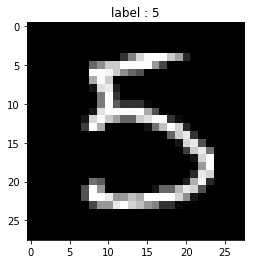

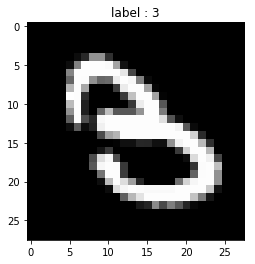

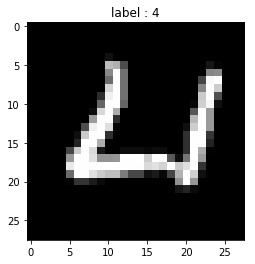

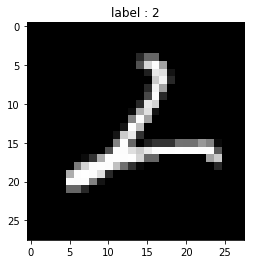

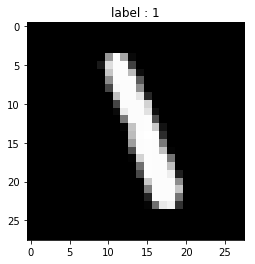

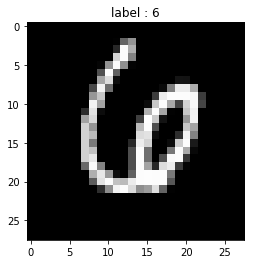

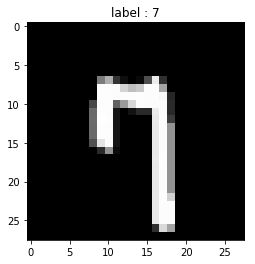

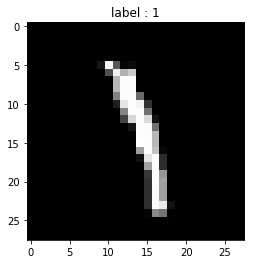

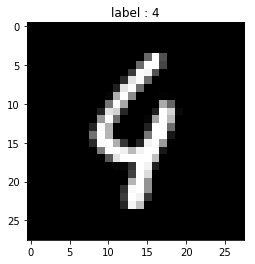

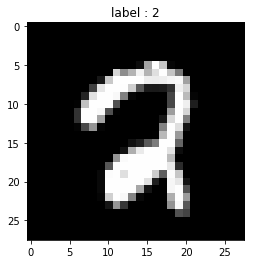

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    index = i
    image = false_X[index].reshape(28,28)
    # X_train[index]: (784,)
    # image: (28, 28)
    plt.imshow(image, 'gray')
    plt.title('label : {}'.format(false_y[index]))
    plt.show()

間違った数字に偏りが若干ある気もするが、無い気もする。

可視化してもあまり良くわからない。

### 更に精度改善を目指す

In [64]:
cnn2d = Scratch2dCNNClassifier(batch_size=100,
                                n_epochs=5,
                                n_iter=500,
                                repeat_batch_process=False,
                                restore_extraction=False,
                                seed=0)

In [65]:
cnn2d.sequential(
    Conv2d(FN=16,FH=5, FW=5,  P=1, S=1), 
    Relu(),
    MaxPool2D(PH=2, PW=2, P=0,S=2),
    Flatten(), 
    FC(512),
    Relu(),
    FC(256), 
    Relu(),
    FC(10), 
    Softmax()
)

input_dim = (1, 28, 28)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(16, 26, 26), param=416
pooling layer shape= (16, 13, 13)
flatten layer shape= 2704
FC layer shape=(2704, 512), param=1384960
FC layer shape=(512, 256), param=131328
FC layer shape=(256, 10), param=2570


In [66]:
cnn2d.fit(X_train, y_train,0.1)

0エポック目のloss= 0.13204
1エポック目のloss= 0.09676
2エポック目のloss= 0.07459
3エポック目のloss= 0.06067
4エポック目のloss= 0.04966


In [67]:
(cnn2d.predict(X_test) == y_test).sum() / len(X_test)

0.9773

**FC層のnode数を増やしたら精度が出た！**

# 【問題7】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。  
フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。  

1.

- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.

- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

In [68]:
cnn2d = Scratch2dCNNClassifier(batch_size=100,
                                n_epochs=5,
                                n_iter=500,
                                repeat_batch_process=False,
                                restore_extraction=False,
                                seed=0)

In [69]:
# 1
cnn2d.sequential(
    Conv2d(FN=6,FH=3, FW=3,  P=0, S=1))

input_dim = (3, 144, 144)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(6, 142, 142), param=168


In [70]:
cnn2d.sequential(
    Conv2d(FN=48,FH=3, FW=3,  P=0, S=1))

input_dim = (24, 60, 60)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(48, 58, 58), param=10416


In [71]:
cnn2d.sequential(
    Conv2d(FN=20,FH=3, FW=3,  P=0, S=1))

input_dim = (10, 20, 20)
cnn2d.initialize(input_dim, summary=True, init_type='He', optimizer=AdaGrad, lr=1e-2)

conv layer shape=(20, 18, 18), param=1820
